In [1]:
import duckdb
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# with duckdb.connect('../data/sakila.duckdb') as con:
#     df = con.sql("SELECT * FROM film").df

con = duckdb.connect('../data/sakila.duckdb')

In [3]:
con.sql("SELECT * FROM film LIMIT 5").df()

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,<NA>,6,0.99,86,20.99,PG,"Deleted Scenes,Behind the Scenes",2021-03-06 15:52:00
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,<NA>,3,4.99,48,12.99,G,"Trailers,Deleted Scenes",2021-03-06 15:52:00
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,<NA>,7,2.99,50,18.99,NC-17,"Trailers,Deleted Scenes",2021-03-06 15:52:00
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,<NA>,5,2.99,117,26.99,G,"Commentaries,Behind the Scenes",2021-03-06 15:52:00
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,<NA>,6,2.99,130,22.99,G,Deleted Scenes,2021-03-06 15:52:00


In [29]:
describe = con.sql("desc;").df()
describe.head()

,database,schema,name,column_names,column_types,temporary
0,sakila,main,actor,"[actor_id, first_name, last_name, last_update]","[DOUBLE, VARCHAR, VARCHAR, TIMESTAMP]",False
1,sakila,main,address,"[address_id, address, address2, district, city...","[BIGINT, VARCHAR, VARCHAR, VARCHAR, BIGINT, VA...",False
2,sakila,main,category,"[category_id, name, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False
3,sakila,main,city,"[city_id, city, country_id, last_update]","[BIGINT, VARCHAR, BIGINT, TIMESTAMP]",False
4,sakila,main,country,"[country_id, country, last_update]","[BIGINT, VARCHAR, TIMESTAMP]",False


## a) Movies longer than 3 hours

In [5]:
films = con.sql("FROM film;").df()

In [6]:
film_length = """--sql
SELECT
    length,
    title
FROM
    film
WHERE
    length > 180;
    """

In [7]:
df = con.sql(film_length).df()
df.head()

,length,title
0,181,ANALYZE HOOSIERS
1,182,BAKED CLEOPATRA
2,183,CATCH AMISTAD
3,185,CHICAGO NORTH
4,184,CONSPIRACY SPIRIT


In [8]:
film_length = films[films['length'] >= 180][['title', 'length']]
film_length.head()

,title,length
15,ALLEY EVOLUTION,180
23,ANALYZE HOOSIERS,181
49,BAKED CLEOPATRA,182
127,CATCH AMISTAD,183
140,CHICAGO NORTH,185


## b) Which movies have the word "love" in its title? Show the following columns
- title
- rating
- length
- description

In [9]:
con.sql("""--sql
SELECT
    title,
    rating,
    length,
    description
FROM
    film
WHERE
    title ILIKE '%love%';""").df()

,title,rating,length,description
0,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
1,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
2,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
3,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
4,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
5,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
6,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...
7,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
8,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
9,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...


In [10]:
films[['title', 'rating', 'length', 'description']]
films[films['title'].str.contains('love', case=False)][['title', 'rating', 'length', 'description']]

,title,rating,length,description
373,GRAFFITI LOVE,PG,117,A Unbelieveable Epistle of a Sumo Wrestler And...
447,IDAHO LOVE,PG-13,172,A Fast-Paced Drama of a Student And a Crocodil...
448,IDENTITY LOVER,PG-13,119,A Boring Tale of a Composer And a Mad Cow who ...
457,INDIAN LOVE,NC-17,135,A Insightful Saga of a Mad Scientist And a Mad...
510,LAWRENCE LOVE,NC-17,175,A Fanciful Yarn of a Database Administrator An...
534,LOVE SUICIDES,R,181,A Brilliant Panorama of a Hunter And a Explore...
535,LOVELY JINGLE,PG,65,A Fanciful Yarn of a Crocodile And a Forensic ...
536,LOVER TRUMAN,G,75,A Emotional Yarn of a Robot And a Boy who must...
537,LOVERBOY ATTACKS,PG-13,162,A Boring Story of a Car And a Butler who must ...
851,STRANGELOVE DESIRE,NC-17,103,A Awe-Inspiring Panorama of a Lumberjack And a...


## c) Calculate descriptive statistics on the length column, The Manager wants, shortest, average, median and longest movie length

Här tar jag fram kortaste, längsta, medellängd och medianlängd för filmer. Jag delar upp det i tre små queries för att det ska vara lätt att läsa.

### Shortest

Här kollar jag vilket längd som är kortast

In [11]:
con.sql("""--sql
SELECT 
    title,
    length
FROM
    film
ORDER BY
    length
LIMIT 5;""").df()

,title,length
0,ALIEN CENTER,46
1,IRON MOON,46
2,KWAI HOMEWARD,46
3,LABYRINTH LEAGUE,46
4,RIDGEMONT SUBMARINE,46


Ser att 46 är kortast så jag tar fram alla filmer som har lengtt som 46

In [12]:
shortest_films = con.sql("""--sql
SELECT 
    title,
    length
FROM
    film
WHERE
    length <= 46
ORDER BY
    length;""").df()

shortest_films

,title,length
0,ALIEN CENTER,46
1,IRON MOON,46
2,KWAI HOMEWARD,46
3,LABYRINTH LEAGUE,46
4,RIDGEMONT SUBMARINE,46


### Average och median

Här tar jag fram average och median längder

In [13]:
con.sql("""--sql
SELECT
    AVG(length) AS average_length,
    MEDIAN(length) AS median_length
FROM
    film;
""").df()

,average_length,median_length
0,115.272,114.0


### Longest

Här kollar jag vilken längd som är den längsta på filmerna

In [14]:
con.sql("""--sql
SELECT 
    title,
    length
FROM
    film
ORDER BY
    length DESC
LIMIT 5;""").df()

,title,length
0,CONTROL ANTHEM,185
1,DARN FORRESTER,185
2,CHICAGO NORTH,185
3,GANGS PRIDE,185
4,HOME PITY,185


Jag ser att 185 är den längsta filmen, så jag sorterar ut det

In [15]:
longest_films = con.sql("""--sql
SELECT 
    title,
    length
FROM
    film
WHERE
    length >= 185
ORDER BY
    length DESC;""").df()

longest_films

,title,length
0,CHICAGO NORTH,185
1,CONTROL ANTHEM,185
2,DARN FORRESTER,185
3,GANGS PRIDE,185
4,HOME PITY,185
5,MUSCLE BRIGHT,185
6,POND SEATTLE,185
7,SOLDIERS EVOLUTION,185
8,SWEET BROTHERHOOD,185
9,WORST BANGER,185


## d) The rental rate is the cost to rent a movie and the rental duration is the number of days a customer can keep the movie. The Manager wants to know the 10 most expensive movies to rent per day.

Här räknar jag ut kostnaden per dag för varje film genom att dividera rental_rate med rental_duration. Sedan sorterar jag filmerna fallande och visar de 10 dyraste per dag

In [16]:
most_expensive_movies_per_day = con.sql("""--sql
SELECT
    title,
    rental_rate,
    rental_duration,
    rental_rate / rental_duration AS cost_per_day
FROM
    film
ORDER BY
    cost_per_day DESC
LIMIT
    10;
""").df()

most_expensive_movies_per_day

,title,rental_rate,rental_duration,cost_per_day
0,BACKLASH UNDEFEATED,4.99,3,1.663333
1,BILKO ANONYMOUS,4.99,3,1.663333
2,BEAST HUNCHBACK,4.99,3,1.663333
3,AUTUMN CROW,4.99,3,1.663333
4,ACE GOLDFINGER,4.99,3,1.663333
5,CARIBBEAN LIBERTY,4.99,3,1.663333
6,BEHAVIOR RUNAWAY,4.99,3,1.663333
7,CASPER DRAGONFLY,4.99,3,1.663333
8,AMERICAN CIRCUS,4.99,3,1.663333
9,CASUALTIES ENCINO,4.99,3,1.663333


## e) Which actors have played in most movies? Show the top 10 actors with the number of movies they have played in.
Här räknar jag hur många filmer varje skådespelare har medverkat i. Jag gör en JOIN mellan actor och film_actor, grupperar per skådis och sorterar resultatet fallande för att få top 10.

In [17]:
con.sql("""--sql
SELECT
    (first_name || ' ' || last_name) AS name,
    -- fa.actor_id,
    COUNT(fa.film_id) AS num_films
FROM
    actor a
JOIN
    film_actor fa ON a.actor_id = fa.actor_id
GROUP BY
    fa.actor_id, name
ORDER BY
    num_films DESC
LIMIT 10;

""").df()

,name,num_films
0,GINA DEGENERES,42
1,WALTER TORN,41
2,MARY KEITEL,40
3,MATTHEW CARREY,39
4,SANDRA KILMER,37
5,SCARLETT DAMON,36
6,VIVIEN BASINGER,35
7,VAL BOLGER,35
8,GROUCHO DUNST,35
9,ANGELA WITHERSPOON,35


# f)

1. Vilka filmer har hyrts flest gånger?

In [18]:
con.sql("""--sql
SELECT
    f.title,
    COUNT(r.rental_id) AS sum_rental
FROM
    film f
JOIN inventory i ON i.film_id = f.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
GROUP BY f.film_id, f.title
ORDER BY sum_rental DESC
LIMIT 10;
""").df()

,title,sum_rental
0,BUCKET BROTHERHOOD,34
1,ROCKETEER MOTHER,33
2,SCALAWAG DUCK,32
3,JUGGLER HARDLY,32
4,RIDGEMONT SUBMARINE,32
5,GRIT CLOCKWORK,32
6,FORWARD TEMPLE,32
7,APACHE DIVINE,31
8,RUSH GOODFELLAS,31
9,GOODFELLAS SALUTE,31


2. Vilka kategorier hyr flest gånger?

Jag kopplar ihop category -> film_category -> film -> inventory -> rental -> customer för att räkna antal hyrningar per kategori. 

In [19]:
con.sql("""--sql
SELECT
    c.name AS category,
    COUNT(r.rental_id) AS sum_rental
FROM
    category c
JOIN film_category fc ON fc.category_id = c.category_id
JOIN film f ON f.film_id = fc.film_id
JOIN inventory i ON i.film_id = f.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN customer cu ON cu.customer_id = r.customer_id
GROUP BY c.category_id, c.name
ORDER BY sum_rental DESC;""").df()

,category,sum_rental
0,Sports,1179
1,Animation,1166
2,Action,1112
3,Sci-Fi,1101
4,Family,1096
5,Drama,1060
6,Documentary,1050
7,Foreign,1033
8,Games,969
9,Children,945


3. Hur många filmer finns i varje rating?

In [20]:
con.sql("""--sql
SELECT
    rating,
    COUNT(rating) AS amount
FROM
    film
GROUP BY
    rating
ORDER BY
    amount DESC;""").df()

,rating,amount
0,PG-13,223
1,NC-17,210
2,R,195
3,PG,194
4,G,178


4. Vilket land hyr flest filmer?

In [21]:
con.sql("""--sql
SELECT
    co.country,
    COUNT(r.rental_id) AS amount
FROM
    rental r
JOIN customer c ON c.customer_id = r.customer_id
JOIN address a ON c.address_id = a.address_id
JOIN city ci ON ci.city_id = a.city_id
JOIN country co ON ci.country_id = co.country_id
GROUP BY
    country
ORDER BY
    amount DESC
LIMIT 10;
""").df()

,country,amount
0,India,1572
1,China,1426
2,United States,968
3,Japan,825
4,Mexico,796
5,Brazil,748
6,Russian Federation,713
7,Philippines,568
8,Turkey,388
9,Indonesia,367


5. Vilka städer har flest kunder?

In [22]:
con.sql("""--sql
SELECT
    city,
    country,
    COUNT(customer_id) AS customer_amount
FROM
    customer c
JOIN address a ON c.address_id = a.address_id
JOIN city ci ON ci.city_id = a.city_id
JOIN country co ON co.country_id = ci.country_id
GROUP BY
    city, country
ORDER BY customer_amount DESC
LIMIT 10;""").df()

,city,country,customer_amount
0,London,United Kingdom,2
1,Aurora,United States,2
2,Amersfoort,Netherlands,1
3,Bat Yam,Israel,1
4,Benin City,Nigeria,1
5,Arlington,United States,1
6,Ambattur,India,1
7,Araatuba,Brazil,1
8,Barcelona,Venezuela,1
9,Beni-Mellal,Morocco,1


# Task 2

a) Who are our top 5 customers by total spend? The Manager wants to know so that they can reward them with special offers. Create a bar chart showing the top 5 customers by total spend.

In [23]:
top_spenders = con.sql("""--sql
SELECT
    first_name || ' ' || last_name AS name,
    SUM(p.amount) AS total_spent,
    c.customer_id
FROM
    customer c
JOIN payment p ON p.customer_id = c.customer_id
GROUP BY name, c.customer_id
ORDER BY total_spent DESC
LIMIT 5;""").df()

top_spenders

,name,total_spent,customer_id
0,KARL SEAL,221.55,526
1,ELEANOR HUNT,216.54,148
2,CLARA SHAW,195.58,144
3,MARION SNYDER,194.61,178
4,RHONDA KENNEDY,194.61,137


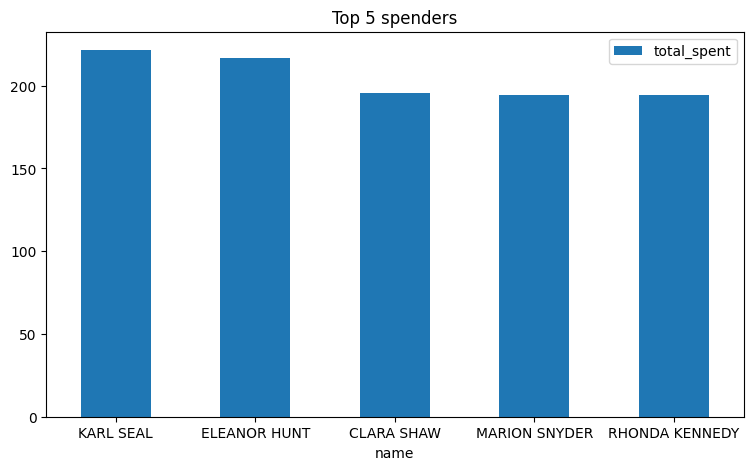

In [24]:
top_spenders.plot(kind='bar', x='name', y='total_spent', title="Top 5 spenders", figsize=(9,5), rot=0,);

b) How much money does each film category bring in? Make a bar chart showing total revenue per film category.

In [25]:
category_earnings = con.sql("""--sql
SELECT
    c.name AS category,
    SUM(p.amount) AS total_revenue
FROM
    category c
JOIN film_category fc ON fc.category_id = c.category_id
JOIN film f ON f.film_id = fc.film_id
JOIN inventory i ON i.film_id = f.film_id
JOIN rental r ON r.inventory_id = i.inventory_id
JOIN payment p ON r.rental_id = p.rental_id
GROUP BY
    c.name
ORDER BY
    total_revenue DESC;
""").df()

category_earnings

,category,total_revenue
0,Sports,5314.21
1,Sci-Fi,4756.98
2,Animation,4656.30
3,Drama,4587.39
4,Comedy,4383.58
5,Action,4375.85
6,New,4351.62
7,Games,4281.33
8,Foreign,4270.67
9,Family,4226.07


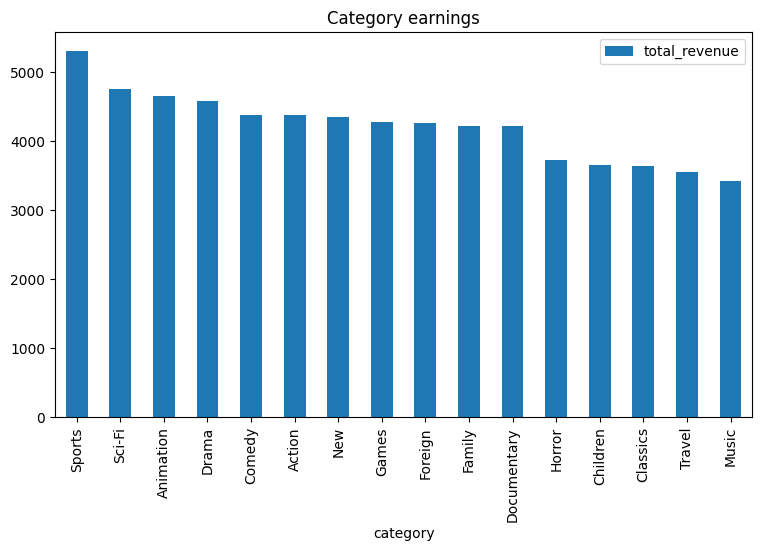

In [26]:
category_earnings.plot(kind='bar', x='category', y='total_revenue', title="Category earnings", figsize=(9,5));

In [27]:
con.sql("""--sql
SELECT
    title
FROM
    film;

""").df()

,title
0,ACADEMY DINOSAUR
1,ACE GOLDFINGER
2,ADAPTATION HOLES
3,AFFAIR PREJUDICE
4,AFRICAN EGG
...,...
995,YOUNG LANGUAGE
996,YOUTH KICK
997,ZHIVAGO CORE
998,ZOOLANDER FICTION
